# CLINT WP5: Inspect how to calculate the average of the anomalies of all the gridpoints in a cluster
### 2023/09/19

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy
import importlib
import seaborn as sns
#from mpl_toolkits import Basemap

In [17]:
import CLINT001_functions as clint
importlib.reload(clint)


NameError: name 'set_maps_lag' is not defined

In [3]:
## DIRECTORIES
machine = 'workstation'

if machine == 'laptop':
    modeldir = '~/Documents/CMCC-GoogleDrive/ERA5/'
    maskdir = '~/Documents/CMCC-GoogleDrive/Mask_Clusters/Test3_Clusters/'
    plotdir = '/Users/squintu/Documents/CMCC-GoogleDrive/plots_for_reports/'
    
if machine == 'workstation':
    modeldir = '~/Documents/CMCC-GoogleDrive/ERA5/'
    maskdir = '~/Documents/CMCC-GoogleDrive/Mask_Clusters/Test3_Clusters/'
    plotdir = '/Users/antonellosquintu/Documents/CMCC-GoogleDrive/plots_for_reports/'

In [4]:
### Read series of tmax and HWMI related to Lake Como
lchw = pd.read_csv('LakeComo_tmax_HW.csv',index_col='date')

In [5]:
### Identify 2019 heat wave

row_maxHWMI = lchw.loc[lchw['Valle_HWintensity'].idxmax()]
date2019_dt = dt.strptime(row_maxHWMI.name,"%Y-%m-%d")
date2019_ts = pd.to_datetime(date2019_dt)

In [6]:
### Identify dates
date_aux_dt = dt.strptime(lchw.loc[lchw.year==1983]['Valle_HWintensity'].idxmax(),"%Y-%m-%d")
date_aux_ts = pd.to_datetime(date_aux_dt)

In [7]:
date_aux_ts

Timestamp('1983-07-21 00:00:00')

In [8]:
## indicate the date of the events and the variables to be included

dates_ts = (pd.to_datetime("2022-07-22"), 
            pd.to_datetime("2019-06-27"), 
            pd.to_datetime("2003-08-11"), 
            pd.to_datetime("1983-07-21"))


vars = ['tmax','mslp','sm']

In [9]:
date_ts = pd.to_datetime("2022-07-22")
var = 'tmax'
importlib.reload(clint)
drivers = pd.read_csv('./metadata/drivers.csv')
y = date_ts.year
drivers_sub = drivers.loc[drivers['var'] == var]
anom_xr = xr.open_dataset(f'{modeldir}/era5_{var}_dailyanom_{y}_cropped.nc')
if var == 'mslp':
    anom_xr['msl'] = anom_xr['msl']/100
drivers_row = drivers_sub.iloc[1]
mask_df = pd.read_csv(f"{maskdir}{drivers_row['clmask_test3']}",index_col=[0])
cl_nr = drivers_row['cl_nr']
submask = mask_df[mask_df.cluster == cl_nr]
maskedanom = clint.mask_xr_w_df(anom_xr, submask)
m = str(date_ts.month).zfill(2)
d = str(date_ts.day).zfill(2)


In [10]:
## Open land-sea mask and round to integer
## The mask has values between 0 and 1 according to the proportion of the grid-point
##  which is covered by land
## Any gridpoint with more than 0.5 is rounded to 1 and considered land

lsm = xr.open_dataset(f'{modeldir}/era5_lsm.nc').round()

In [42]:
def apply_land_sea_mask(targetxr, lsm):
    
    ## The era5 netcdf is adapted to the format of maskedanom,
    ##  so that the mask can be applied
    lsm_mask = lsm.reindex(longitude=targetxr.longitude, 
                            latitude=targetxr.latitude,
                            method="nearest", 
                            tolerance=1e-9, 
                            fill_value=0).squeeze()


    ## Maskedanom is updated removing the gridpoints on the sea
    outputxr = targetxr.where(lsm_mask['lsm'])
    return(outputxr)
    


In [34]:
## The era5 netcdf is adapted to the format of maskedanom,
##  so that the mask can be applied
lsm_mask = lsm.reindex(longitude=maskedanom.longitude, 
                        latitude=maskedanom.latitude,
                        method="nearest", 
                        tolerance=1e-9, 
                        fill_value=0).squeeze()


## Maskedanom is updated removing the gridpoints on the sea
maskedanom = maskedanom.where(lsm_mask['lsm'])

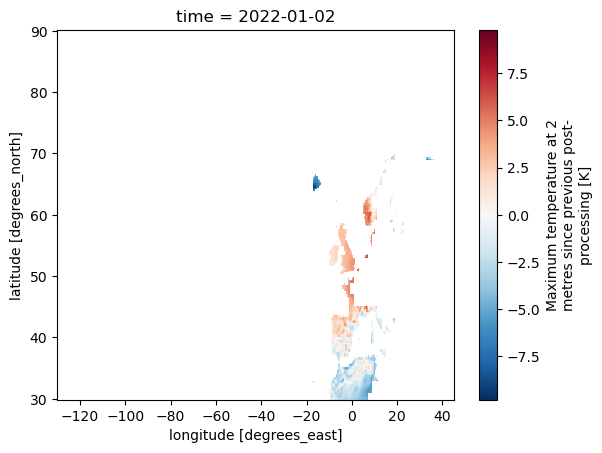

In [41]:
maskedanom1.isel(time=1)['mx2t'].plot()

In [18]:
    ## Generate coordinates of all gridpoints around the 2x2
    exp_list = [clint.expand_res_grid(row) for index,row in submask.iterrows()] 
    ## Concatenate dataframes with all the new gridpoints
    exp_df = pd.concat(exp_list,ignore_index=True).reset_index(drop=True)
    exp_df['cluster'] = np.nanmean(submask['cluster']) #add the missing column so that it can be merged to submask
    ## Append the new gridpoints to the original 2x2 mask
    submask_exp = pd.concat([submask,exp_df],ignore_index=True).drop_duplicates().reset_index(drop=True)

In [20]:
    mask = submask_exp.assign(flag=1).set_index(["nodes_lon", "nodes_lat"]).flag.to_xarray().fillna(0).rename({"nodes_lon": "longitude", "nodes_lat": "latitude"})

In [21]:
mask

<xarray.DataArray 'flag' (longitude: 210, latitude: 169)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])
Coordinates:
  * longitude  (longitude) float64 -17.0 -16.75 -16.5 -16.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float64 29.0 29.25 29.5 29.75 ... 70.5 70.75 71.0

In [ ]:
    mask = mask.reindex(longitude=xrdf.longitude, 
                        latitude=xrdf.latitude,method="nearest", tolerance=1e-9, fill_value=0)

    sub_xrdf = xrdf.where(mask)

In [82]:
## need to set the dartew
maskedanom1 = maskedanom.where(lsm_mask1['lsm'])


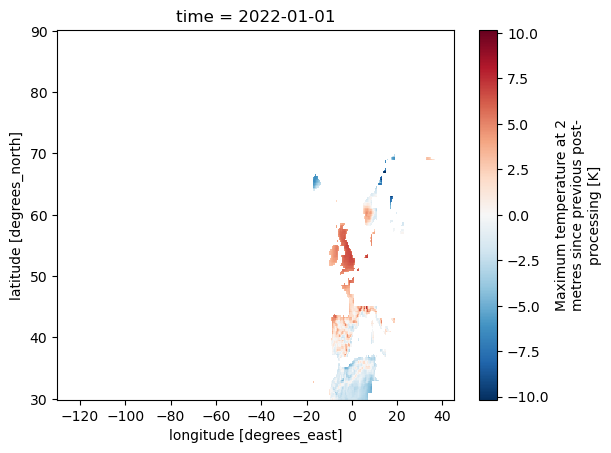

In [85]:
maskedanom1['mx2t'].plot()

In [36]:

xrdf = maskedanom1
target_ts = date_ts

In [37]:
xrdf

<xarray.Dataset>
Dimensions:    (time: 1, longitude: 701, latitude: 241)
Coordinates:
  * time       (time) datetime64[ns] 2022-01-01
  * longitude  (longitude) float32 -130.0 -129.8 -129.5 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 30.5 30.25 30.0
Data variables:
    *empty*
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Aug 16 14:41:27 2023: cdo -b 32 -ydaysub /work/csp/as18...
    frequency:    day
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...

In [35]:
xrdf.mean(dim=['time'])['mx2t'].plot

KeyError: 'mx2t'

In [24]:
xrdf.mean(dim=['longitude','latitude'])['mx2t']

<xarray.DataArray 'mx2t' (time: 365)>
array([ 0.42351657,  0.05918003, -0.43711472, -1.4853247 , -2.173118  ,
       -2.1411107 , -1.8009018 , -1.4202169 , -0.8700403 , -0.14597824,
       -0.19261755, -0.23375006, -0.74390984, -1.2046171 , -1.0723623 ,
       -1.5443847 , -1.1862532 , -0.54985166, -1.9631325 , -1.9036436 ,
       -1.0252897 , -0.66937685, -0.6120944 , -1.5594891 , -1.3321929 ,
       -1.2211499 , -1.5139412 , -0.96382475, -1.0122644 , -1.333848  ,
       -1.3571472 , -1.1880196 , -0.9393874 , -0.55626154, -0.8960367 ,
       -0.86420774, -1.0408144 , -0.6398365 , -0.5641433 , -1.1342757 ,
       -1.8538359 , -1.7829014 , -1.371632  , -1.3753912 , -1.4029299 ,
       -1.0034932 , -0.5674812 , -0.7780168 , -1.3351735 , -1.2339815 ,
       -0.6498113 , -0.7663067 , -0.73124784, -0.8491147 , -1.4170045 ,
       -1.382839  , -0.3652362 , -0.39553472, -0.33646965, -0.8606245 ,
       -1.0355196 , -1.2307627 , -1.8184457 , -1.8900901 , -1.8273374 ,
       -1.9070445 , -1.3620157 , -0.9393907 , -0.39234486, -0.14454743,
       -0.5162203 , -0.6854989 , -0.39172855, -0.07257384, -0.70711696,
       -0.9130276 , -0.59377116, -0.0806707 , -0.32172292, -0.7665321 ,
       -0.5648502 , -0.7879609 , -0.8053684 , -0.9591506 , -0.66969234,
       -0.32196864, -1.0236167 , -1.6843214 , -2.2300448 , -2.8994637 ,
       -3.327535  , -3.358285  , -3.1008093 , -2.916226  , -2.7780054 ,
       -2.2950795 , -2.1713808 , -2.2177896 , -2.0450184 , -1.4010128 ,
...
       -1.596184  , -1.6006547 , -1.301561  , -0.81885004, -0.27602875,
        0.10035536,  0.15134642, -0.16764443, -0.39441887, -0.6530378 ,
       -0.8987012 , -0.34704775, -0.7628132 , -1.0519978 , -0.5485421 ,
       -0.38909698, -0.3792849 , -0.33948687, -0.106146  ,  0.02764595,
        0.18755345, -0.05285482,  0.01802813, -0.02667123, -0.2688911 ,
       -0.11824339,  0.12080505,  0.62928444,  0.9593286 ,  1.2619405 ,
        1.1022536 ,  0.7151936 ,  0.9535814 ,  1.1205467 ,  0.67401016,
        0.58690614,  0.3886477 ,  0.00603411, -0.25359297, -0.05132781,
        0.34672672,  0.61256444,  0.7509795 ,  1.1957006 ,  1.549201  ,
        1.4197265 ,  1.0936183 ,  0.9059616 ,  1.0012071 ,  1.0985906 ,
        0.8984646 , -0.0275841 , -0.6478532 , -0.8774716 , -0.90982085,
       -0.8834305 ,  0.07475111,  0.42565373,  0.66285276,  0.81070894,
        0.5317223 , -0.02449724, -0.37974188, -0.1671875 , -0.25785822,
       -0.6656784 , -1.2255447 , -1.3091713 , -1.0449759 , -1.4975153 ,
       -1.9010607 , -1.7448131 , -1.3079299 , -1.9925786 , -2.1059728 ,
       -1.6934333 , -1.6823555 , -1.6162852 , -2.467641  , -2.7956982 ,
       -2.394823  , -1.3645495 , -0.17500287,  0.02948611,  0.05530072,
       -0.34594634, -0.95137507, -0.9647287 , -0.56418115, -0.8134582 ,
       -0.94700897, -0.7739149 , -0.7489917 , -0.20931613, -0.5475989 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-12-31

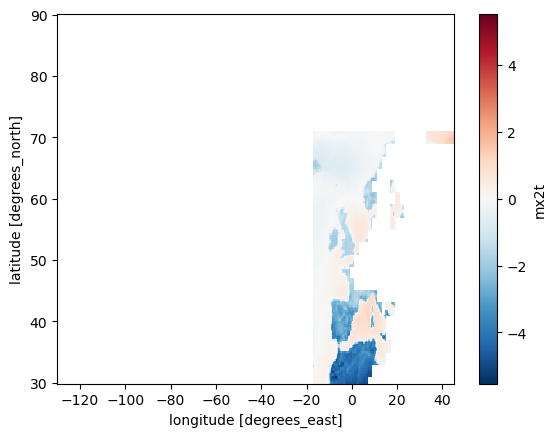

In [22]:
xrdf.mean(dim='time')['mx2t'].plot()